### Trajectory Optimization
1. Trajectory optimization is concerned with finding the optimal trajectory given some objective functions, for example minimal force or minimal work:
<br> $$\min_{u(t),x(t),v(t)} \int_{0}^1 u^2 (\tau) d\tau$$
<br> $$\min_{u(t),x(t),v(t)} \int_{0}^1 |u (\tau) v(\tau)| d\tau$$

2. A standard trajectory optimization problem consists of two terms, a *mayer* term that captures boundary conditions and a *lagrange* term that is a path integral along the entire trajectory:
<br> $$\min_{t_0,t_f,u(t),\mathbf{x}(t),\mathbf{v}(t)} J(t_0,t_f,\mathbf{x}(t_0),\mathbf{x}(t_f)) + \int_{t_0}^{t_f} w(\tau,\mathbf{x}(\tau),\mathbf{u}(\tau)) d\tau$$

#### Direct Collocation Methods
1. Direct collocation operates by transcribing a trajectory generation problem in to a nonlinear program.

2. Simple example: Consider moving a unit mass from rest at $x=0$ to stop at $x=1$ in $1$ second.
<br> $$\min_{u(t),x(t),v(t)} \int_{0}^1 u^2 (\tau) d\tau$$
<br> $$u^* = 6-12t, x^* = 3t^2 - 2t^3$$
where the second euqation is found from calculus of variations

3. To begin, we need to discretize the trajectory, which gives a finite set of decision variables. This is done by setting up collocation points:
$$t \rightarrow t_0 ... t_k ... t_N$$
$$x \rightarrow x_0 ... x_k ... x_N$$
$$v \rightarrow v_0 ... v_k ... v_N$$
Using trapezoidal collocation, we approximate the change in state in the continuous function $\dot x = v$ as $x_{k+1}-x_k \approx \frac{1}{2} h_k (v_{k+1}+v_k)$. Also, for $\ddot x = u$, we have $v_{k+1}-v_k \approx \frac{1}{2} h_k (u_{k+1}+u_k)$. The boundary conditions are $x_0 = v_0 = v_N = 0$ and $x_N = 1$. Discretizing the objective function, we have:
<br> $$\min_{u(t)} \int_{t_0}^{t_N} u^2 (\tau) d\tau \approx \min_{u_0 .. u_N} \sum_{k=0}^{N-1} \frac{1}{2} h_k (u_k^2+u_{k+1}^2)$$

4. *Initialization* - to kickstart the nonlinear program, we need initial guesses. A simple trajectory for our problem is a ramp. Evaluating the guessed trajectory at each collocation point, we can obtain values to pass to the nonlinear program

5. *Interpolation* - To reconstruct trajectories from the knot points, we construct the conrol trajectory as a piece-wise linear function, i.e. $u(t) \approx u_k + \frac{\tau}{h_k}(u_{k+1}-u_k)$ where $\tau = t-t_k$ and $h_k = t_{k+1}-t_k$. The state trajectory, however, is represented by a quadratic spline. This is because the dynamics was approximated as a linear function, $f(t) = \dot x(t) \approx f_k + \frac{\tau}{h_k}(f_{k+1}-f_k)$. To recover $x(t)$, we will need to integrate the linear function, resulting in the quadratic $x(t) \approx x_k + f_k \tau + \frac{\tau^2}{2h_k}(f_{k+1}-f_k)$

##### Example 1: Double integrator

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      804
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      101

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      204
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

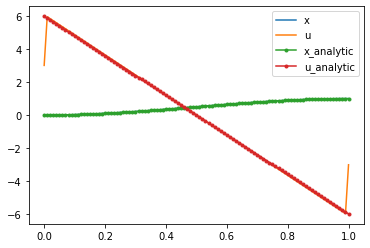

In [32]:
# Example 1: moving a unit mass from x=0 to x=1 in 1s. Here control is unbounded.
# To add actuation saturation, simply include "opti.subject_to(u <= 5)" and "opti.subject_to(-5 <= u)"
# requires casadi, simply run "pip install casadi" to install
from casadi import *
import numpy as np
import matplotlib.pyplot as plt

N = 100
hk = 0.01

# analytic solution
t = np.linspace(0,1,N+1);
u_analytic = 6-12*t
x_analytic = 3*np.power(t,2) - 2*np.power(t,3)

# nonlinear optimization
opti = casadi.Opti()

x = opti.variable(N+1) # 0~N
v = opti.variable(N+1)
u = opti.variable(N+1)

# constraints with trapezoidal 
opti.subject_to(x[0] == 0)
opti.subject_to(v[0] == 0)
opti.subject_to(x[N] == 1)
opti.subject_to(v[N] == 0)
for k in range(N):
    opti.subject_to( x[k+1] - x[k] == 0.5 * hk * (v[k+1] + v[k]))
    opti.subject_to( v[k+1] - v[k] == 0.5 * hk * (u[k+1] + u[k]))

# objective function
opti.minimize(sumsqr(u))

# initial guess
opti.set_initial(x, np.linspace(0,1,N+1))
opti.set_initial(v, np.ones((1,N+1)))
opti.set_initial(u, np.zeros((1,N+1)))

# solve
opti.solver("ipopt") #,p_opts, s_opts)
sol = opti.solve()

# solution
plt.plot(t, sol.value(x), label="x")
plt.plot(t, sol.value(u), label="u")
plt.plot(t, x_analytic, label="x_analytic", marker='.')
plt.plot(t, u_analytic, label="u_analytic", marker='.')
plt.legend()
plt.show()

##### Example 2: Cart pole swing up
![cart_pole](resource/cart_pole.png)

The equations of motion are given by:
$$\ddot q_1 = \frac{L m_2 sin(q_2) \dot q_2^2 + u + m_2 g cos(q_2) sin(q_2)}{m_1 + m_2 (1-cos^2(q_2))}$$
$$\ddot q_2 = \frac{L m_2 cos(q_2) sin(q_2) \dot q_2^2 + u cos (q_2) + (m_1 + m_2) g sikn(q_2)}{L m_1 + L m_2 (1-cos^2(q_2))}$$

And the state vector is given by $$x = \begin{bmatrix} q_1 \\ q_2 \\ \dot q_1 \\ \dot q_2 \end{bmatrix}$$

In [ ]:
import pybullet as p
import pybullet_data
physicsClient = p.connect(p.GUI)#or p.DIRECT for non-graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #used by loadURDF
p.setGravity(0, 0, -9.81)

# Import cart pole
planeId = p.loadURDF("plane.urdf")
startPos = [0,0,1.5]
startOrientation = p.getQuaternionFromEuler([0,0,0])
cartPoleId = p.loadURDF("./resource/cart_pole.urdf",startPos, startOrientation)

# Free the joints
p.setJointMotorControl2(cartPoleId, 0, p.VELOCITY_CONTROL, force=0)
p.setJointMotorControl2(cartPoleId, 1, p.VELOCITY_CONTROL, force=0)

# Setup torque control

# Simulate
p.setRealTimeSimulation(1)
for i in range(10000000):
    pos, orn = p.getBasePositionAndOrientation(cartPoleId)
#     print(cubePos,cubeOrn)
p.disconnect()

In [ ]:
import nlopt
from numpy import *

def myfunc(x, grad):
    if grad.size > 0:
        grad[0] = 0.0
        grad[1] = 0.5 / sqrt(x[1])
    return sqrt(x[1])

def myconstraint(x, grad, a, b):
    if grad.size > 0:
        grad[0] = 3 * a * (a*x[0] + b)**2
        grad[1] = -1.0
    return (a*x[0] + b)**3 - x[1]

opt = nlopt.opt(nlopt.LN_AUGLAG, 2)
opt.set_lower_bounds([-float('inf'), 0])
opt.set_min_objective(myfunc)
opt.add_inequality_constraint(lambda x,grad: myconstraint(x,grad,2,0), 1e-8)
opt.add_inequality_constraint(lambda x,grad: myconstraint(x,grad,-1,1), 1e-8)
opt.set_xtol_rel(1e-4)
x = opt.optimize([1.234, 5.678])
minf = opt.last_optimum_value()
print("optimum at ", x[0], x[1])
print("minimum value = ", minf)
print("result code = ", opt.last_optimize_result())

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      812
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      180
                     variables with only lower bounds:       80
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:      160
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

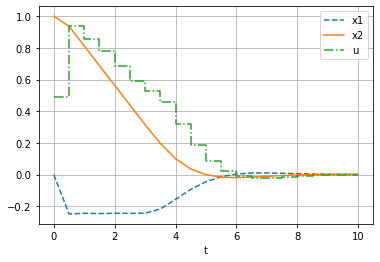

In [26]:
# requires casadi, simply run "pip install casadi" to install

import casadi as ca
import numpy as NP
import matplotlib.pyplot as plt

# Degree of interpolating polynomial
d = 3

# Get collocation points
tau_root = np.append(0, ca.collocation_points(d, 'radau'))

# Coefficients of the collocation equation
C = np.zeros((d+1,d+1))

# Coefficients of the continuity equation
D = np.zeros(d+1)

# Coefficients of the quadrature function
B = np.zeros(d+1)

# Construct polynomial basis
for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
    p = np.poly1d([1])
    for r in range(d+1):
        if r != j:
            p *= np.poly1d([1, -tau_root[r]]) / (tau_root[j]-tau_root[r])

    # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
    D[j] = p(1.0)

    # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
    pder = np.polyder(p)
    for r in range(d+1):
        C[j,r] = pder(tau_root[r])

    # Evaluate the integral of the polynomial to get the coefficients of the quadrature function
    pint = np.polyint(p)
    B[j] = pint(1.0)
    
# Time horizon
T = 10.

# Declare model variables
x1 = ca.SX.sym('x1')
x2 = ca.SX.sym('x2')
x = ca.vertcat(x1, x2)
u = ca.SX.sym('u')

# Model equations of Van Der Pol oscillator with mu = 1
xdot = ca.vertcat((1-x2**2)*x1 - x2 + u, x1)

# Objective term
L = x1**2 + x2**2 + u**2

# Continuous time dynamics
f = ca.Function('f', [x, u], [xdot, L], ['x', 'u'], ['xdot', 'L'])

# Control discretization
N = 20 # number of control intervals
h = T/N

# Start with an empty NLP
w = []
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

# For plotting x and u given w
x_plot = []
u_plot = []

# "Lift" initial conditions
Xk = ca.MX.sym('X0', 2)
w.append(Xk)
lbw.append([0, 1])
ubw.append([0, 1])
w0.append([0, 1])
x_plot.append(Xk)

# Formulate the NLP
for k in range(N):
    # New NLP variable for the control
    Uk = ca.MX.sym('U_' + str(k))
    w.append(Uk)
    lbw.append([-1])
    ubw.append([1])
    w0.append([0])
    u_plot.append(Uk)

    # State at collocation points
    Xc = []
    for j in range(d):
        Xkj = ca.MX.sym('X_'+str(k)+'_'+str(j), 2)
        Xc.append(Xkj)
        w.append(Xkj)
        lbw.append([-0.25, -np.inf])
        ubw.append([np.inf,  np.inf])
        w0.append([0, 0])

    # Loop over collocation points
    Xk_end = D[0]*Xk
    for j in range(1,d+1):
       # Expression for the state derivative at the collocation point
       xp = C[0,j]*Xk
       for r in range(d): xp = xp + C[r+1,j]*Xc[r]

       # Append collocation equations
       fj, qj = f(Xc[j-1],Uk)
       g.append(h*fj - xp)
       lbg.append([0, 0])
       ubg.append([0, 0])

       # Add contribution to the end state
       Xk_end = Xk_end + D[j]*Xc[j-1];

       # Add contribution to quadrature function
       J = J + B[j]*qj*h

    # New NLP variable for state at end of interval
    Xk = ca.MX.sym('X_' + str(k+1), 2)
    w.append(Xk)
    lbw.append([-0.25, -np.inf])
    ubw.append([np.inf,  np.inf])
    w0.append([0, 0])
    x_plot.append(Xk)

    # Add equality constraint
    g.append(Xk_end-Xk)
    lbg.append([0, 0])
    ubg.append([0, 0])

# Concatenate vectors
w = ca.vertcat(*w)
g = ca.vertcat(*g)
x_plot = ca.horzcat(*x_plot)
u_plot = ca.horzcat(*u_plot)
w0 = np.concatenate(w0)
lbw = np.concatenate(lbw)
ubw = np.concatenate(ubw)
lbg = np.concatenate(lbg)
ubg = np.concatenate(ubg)

# Create an NLP solver
prob = {'f': J, 'x': w, 'g': g}
solver = ca.nlpsol('solver', 'ipopt', prob);

# Function to get x and u trajectories from w
trajectories = ca.Function('trajectories', [w], [x_plot, u_plot], ['w'], ['x', 'u'])

# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
x_opt, u_opt = trajectories(sol['x'])
x_opt = x_opt.full() # to numpy array
u_opt = u_opt.full() # to numpy array

# Plot the result
tgrid = np.linspace(0, T, N+1)
plt.figure(1)
plt.clf()
plt.plot(tgrid, x_opt[0], '--')
plt.plot(tgrid, x_opt[1], '-')
plt.step(tgrid, np.append(np.nan, u_opt[0]), '-.')
plt.xlabel('t')
plt.legend(['x1','x2','u'])
plt.grid()
plt.show()

In [ ]:
from casadi import *
import matplotlib.pyplot as plt

g = 9.8
N = 100

x = SX.sym('x',N)
v = SX.sym('v', N)
u = SX.sym('u', N-1)
#theta = SX('theta', N)
#thdot = SX('thetadot', N)

dt = 0.1
constraints = [x[0]-1, v[0]] # expressions that must be zero
for i in range(N-1):
    constraints += [x[i+1] - (x[i] + dt * v[i]) ]
    constraints += [v[i+1] - (v[i] - dt * x[i+1] + u[i] * dt)]

cost = sum([x[i]*x[i] for i in range(N)]) + sum([u[i]*u[i] for i in range(N-1)])

nlp = {'x':vertcat(x,v,u), 'f':cost, 'g':vertcat(*constraints)}
S = nlpsol('S', 'ipopt', nlp)
r = S(lbg=0, ubg=0) # can also give initial solutiuon hint, some other things
x_opt = r['x']
x = x_opt[:N]
v = x_opt[N:2*N]
u = x_opt[2*N:]
#u_opt = r['u']
print('x_opt: ', x_opt)
print(S)
plt.plot(x)
plt.plot(u)
plt.plot(v)
plt.show()

